In [2]:
import pandas as pd
import random
from datetime import datetime
import uuid
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

HOUR_IN_SECONDS = 3600

def read_csv(path: str, sep: str):
  return pd.read_csv(path, sep=sep)

airport_acronym = "SBGR" # Sigla ICAO do Aeroporto que vamos analisar # Garulhos

In [3]:
br = read_csv("database/aerodromospublicosv1.csv", sep=";")
brazilian_airports = br["CÓDIGO OACI"].tolist()

In [4]:
df = read_csv("database/VRA_2023_01.csv", sep=';') # Dados Janeiro 2023

isOrigin = df['Sigla ICAO Aeroporto Origem'] == airport_acronym
isDest = df['Sigla ICAO Aeroporto Destino'] == airport_acronym

hasLadingData = ~pd.isna(df['Partida Prevista'])
hasTakeOffData = ~pd.isna(df['Chegada Prevista'])

mask = (isOrigin | isDest) & hasLadingData & hasTakeOffData

df = df[mask]

df = df[df['Sigla ICAO Aeroporto Origem'].isin(brazilian_airports)]
df = df[df['Sigla ICAO Aeroporto Destino'].isin(brazilian_airports)]

df['Partida Prevista'] = pd.to_datetime(df['Partida Prevista'], format='%d/%m/%Y %H:%M')
df['Chegada Prevista'] = pd.to_datetime(df['Chegada Prevista'], format='%d/%m/%Y %H:%M')

dados = {
    'origin': df['Sigla ICAO Aeroporto Origem'],
    'destination': df['Sigla ICAO Aeroporto Destino'],
    'landing_datetime': df['Chegada Prevista'],
    'landing_date': df['Chegada Prevista'].dt.date,
    'landing_time': df['Chegada Prevista'].dt.time,
    'takeoff_datetime': df['Partida Prevista'],
    'takeoff_date': df['Partida Prevista'].dt.date,
    'takeoff_time': df['Partida Prevista'].dt.time,
}

data_frame = pd.DataFrame(data = dados, index=None)

In [5]:
def graph_by_date(specific_date: str, df):

  nodes = {
      "Id": [],
      "Label": [],
      "landing_datetime": []
  }

  edges = {
      "Source": [],
      "Target": [],
      "Type": [],
      "Id": [],
      "Label": [],
  }

  df['landing_date'] = pd.to_datetime(df['landing_date'], format='%Y/%m/%d')
  df['landing_time'] = pd.to_datetime(df['landing_time'], format='%H:%M:%S')

  df['takeoff_date'] = pd.to_datetime(df['takeoff_date'], format='%Y/%m/%d')
  df['takeoff_time'] = pd.to_datetime(df['takeoff_time'], format='%H:%M:%S')

  landing_check = df['landing_date'].dt.date == pd.to_datetime(specific_date, format='%d/%m/%Y').date()
  takeoff_check = df['takeoff_date'].dt.date == pd.to_datetime(specific_date, format='%d/%m/%Y').date()

  filtered_df = df[landing_check | takeoff_check]

  # filtered_df.to_csv('/content/drive/MyDrive/AEDS/output/filtered.csv', index=False)

  nodes['Id'] = list(range(0, len(filtered_df)))
  nodes['Label'] = list(range(0, len(filtered_df)))
  nodes['landing_datetime'] = filtered_df['landing_datetime']

  def add_edge(source, target, label):
    edges['Id'].append(uuid.uuid4())
    edges['Label'].append(label)
    edges['Source'].append(source)
    edges['Target'].append(target)
    edges['Type'].append("Undirected")

  def different_in_seconds(date1, date2):
    time1 = date1.timestamp()
    time2 = date2.timestamp()
    return abs(time1 - time2)


  for (i, f1), (j, f2) in combinations(filtered_df.iterrows(), 2):

    if f1['origin'] == airport_acronym and f2['origin'] == airport_acronym:
        diff_in_seconds = different_in_seconds(f1["landing_datetime"], f2["landing_datetime"])
        if diff_in_seconds <= HOUR_IN_SECONDS:
            add_edge(i, j, diff_in_seconds)

    elif f1['destination'] == airport_acronym and f2['destination'] == airport_acronym:
        diff_in_seconds = different_in_seconds(f1["takeoff_datetime"], f2["takeoff_datetime"])
        if diff_in_seconds <= HOUR_IN_SECONDS:
            add_edge(i, j, diff_in_seconds)

    elif f1['origin'] == airport_acronym and f2['destination'] == airport_acronym:
        diff_in_seconds = different_in_seconds(f1["landing_datetime"], f2["takeoff_datetime"])
        if diff_in_seconds <= HOUR_IN_SECONDS:
            add_edge(i, j, diff_in_seconds)

    elif f1['destination'] == airport_acronym and f2['origin'] == airport_acronym:
        diff_in_seconds = different_in_seconds(f1["takeoff_datetime"], f2["landing_datetime"])
        if diff_in_seconds <= HOUR_IN_SECONDS:
            add_edge(i, j, diff_in_seconds)

  nodes_df = pd.DataFrame(nodes)
  # nodes_df.to_csv('/content/drive/MyDrive/AEDS/graph/nodes.csv', index=False)

  edges_df = pd.DataFrame(edges)
  # edges_df.to_csv('/content/drive/MyDrive/AEDS/graph/edges.csv', index=False)

  return nodes_df, edges_df

In [6]:
def greedy_coloring(graph):
    color_dict = {}

    for node in graph.nodes():

        neighbor_colors = {color_dict[neighbor] for neighbor in graph.neighbors(node) if neighbor in color_dict}

        color = 0
        while color in neighbor_colors:
            color += 1

        color_dict[node] = color

    return color_dict


def run_algo(edges_df, nodes_df):
  graph = nx.from_pandas_edgelist(edges_df, "Source", "Target", 'Label')

  c = nx.coloring.greedy_color(graph, strategy="largest_first")

  central_node = max(graph.nodes, key=graph.degree)
  central_edges = [(central_node, neighbor) for neighbor in graph.neighbors(central_node)]
  # new_graph = nx.Graph(central_edges)

  result = nodes_df.loc[nodes_df.index == central_node, 'landing_datetime'].values[0]

  all_cliques = list(nx.find_cliques(graph))
  max_clique = max(all_cliques, key=len)
    
  return {
      'min_colors': max(list(c.values())) + 1,
      'max_degree': len(central_edges),
      'max_clique': len(max_clique),
      'central_datetime': result.astype(datetime)
  }


In [7]:
import calendar

graphic = {
    'colors': [],
    'degrees': [],
    'cliques': [],
    'dates': [],
}

_, num_days = calendar.monthrange(2023, 1)

for day in range(1, num_days + 1):

    specific_date = f"{day:02d}/{1:02d}/{2023}"
    
    res = graph_by_date(specific_date, data_frame)

    n_df = res[0]
    e_df = res[1]

    data = run_algo(e_df, n_df)

    # print(data)

    graphic['colors'].append(data['min_colors'])
    graphic['degrees'].append(data['max_degree'])
    graphic['cliques'].append(data['max_clique'])
    graphic['dates'].append(data['central_datetime'])

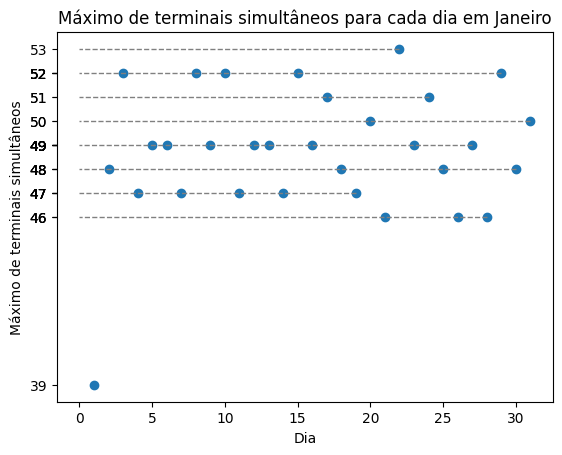

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = 'notebook'

x = list(range(1, 32))
y = graphic['colors']

fig, ax = plt.subplots()

ax.plot(x, y, 'o', label='Data Points')

plt.yticks(y)

y_values = set()

for i in range(len(x) - 1, 0, -1):
    if y[i] not in y_values:
        ax.plot([x[i], 0], [y[i], y[i]], '--', color='gray', linewidth=1)
        y_values.add(y[i])

plt.xlabel('Dia')
plt.ylabel('Máximo de terminais simultâneos')
plt.title('Máximo de terminais simultâneos para cada dia em Janeiro')

plt.show()

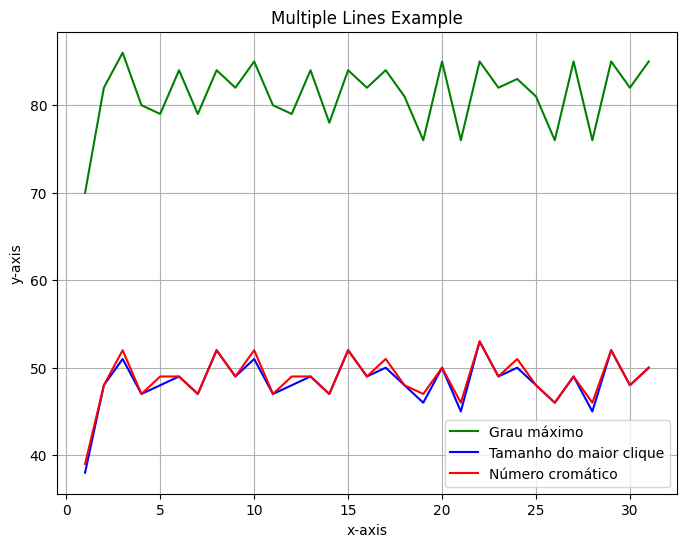

In [15]:
# Create some sample data
x = list(range(1, 32)) # days
y1 = graphic['colors']
y2 = graphic['degrees']
y3 = graphic['cliques']

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(x, y2, label='Grau máximo', color='green')
plt.plot(x, y3, label='Tamanho do maior clique', color='blue')
plt.plot(x, y1, label='Número cromático', color='red')

# Add labels and a legend
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Multiple Lines Example')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [31]:


for time in graphic['dates']:
    timestamp_seconds = time / 1e9
    date_time = datetime.utcfromtimestamp(timestamp_seconds)
    hour = date_time.hour
    print(hour, date_time.minute)


21 55
11 25
11 35
11 30
11 25
11 25
11 25
11 25
11 25
11 35
11 30
11 25
11 25
11 25
11 25
11 25
11 35
11 30
11 25
11 25
11 25
11 25
11 25
11 35
11 30
11 25
11 25
11 25
11 25
11 25
11 35
